In [72]:
import numpy as np

###########
# constants
###########

n =  10  # number of PCBsats left in cubesat
m_stac = 100 * (10 ** -3)  # mass of individual stac (KILOGRAMS)

#R_z_dot = # tbd, this is our stack velocity in the z direction
#R_z = # array of vertical positions of each stack

dt = 1  # SECONDS

#w_motor =  # motor ang velocity (radians per second)
#l_screw =  # screw lead (meters)
#r_screw =  # screw radius (meters)
#v =  (w_motor * l_screw) / (2 * np.pi)  # linear velocity of screw shaft (meters per second)

# 3x3 matrix for moment of inertia of cubesat without stacs
MOI_cube = np.array([
    [1308846.485, -10374.412, -13883.462],
    [-10374.412, 1334376.646, -21514.642],
    [-13883.462,-21514.642, 671472.124]]) / 1000000

# 3x3 matrix giving moment of inertia of an individual stac about it's own axis
MOI_stac = np.array([
    [1/12 * (10.1 ** (-4)), 0, 0],
    [0, 1/12 * (10.1 ** (-4)), 0], 
    [0, 0, 1/60000]
])


# nx3 length v giving the x y z locations of the stacs
positions = np.array([
    [0, 0, 7.5],
    [0, 0, 9],
    [0, 0, 10.5],
    [0, 0, 12],
    [0, 0, 13.5],
    [0, 0, 15],
    [0, 0, 16.5],
    [0, 0, 18],
    [0, 0, 19.5],
    [0, 0, 21]
])

##################
# helper functions
##################

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@ double check correctness
def v_shaft(w_motor, l_screw):
    return (w_motor * l_screw) / (2 * np.pi)

# note that R_z_dot 
#def make_J_dot(R_x, R_y, R_z_dot, n):
#    xz = -n * m_stac * R_x * R_z_dot
#    yz = -n * m_stac * R_y * R_z_dot
#    return np.matrix([[0,  0,  xz],
#                     [0,  0,  yz],
#                      [xz, yz, 0]])

#find moment of inertia of cubesat

def inertia_of_cubesat(MOI_cube, MOI_stac, n, positions):
    
    MOI_mat = np.empty([3,3])
        
    for i in range(3):
        for j in range(3):
                       
            sumaij = 0
            
            for x in range(n):
                if i != j:
                    
                    #g = 0
                    aij = - positions[x,i] * positions[x,j]
                    
                else:
                    #aij = positions[x,i] * positions[x,j]
                    aij = 0
                        
                    #The equation for this is I_{ij}new = I_{ij} + M[delta_{ij}(a_i*a_j) - a_i*a_j]
                
                sumaij += aij
                
            
            #MOI_mat[i,j] = MOI_cube[i,j] + n * MOI_stac[i,j] + m_stac*sumaij
            MOI_mat[i,j] = n * MOI_stac[i,j] + m_stac*sumaij
    return MOI_mat




# REWRITING ABOVE FUNCTION IN MATRIX FORM
# Note: Assumes we can add inertia tensors linearly. CHECK ASSUMPTION
def get_inertial_matrix(MOI_cube, MOI_stac, n, positions):
    J_global = 0
    
    for i in range(n):
        r = positions[i][np.newaxis, :].T
        r_squared = np.dot(positions[i], positions[i])
        
        J = MOI_stac + m_stac * (r_squared * np.identity(3) - r * positions[i])
        J_global += J
    
    return J_global + MOI_cube






### TBD
* update stac vertical positions at each time step
* compute inertial matrix based on positions
* encode some way of adjusting inertial matrix when a stac is released (if z > threshold: DECREASE N BY ONE??)
* 
* NEW PLAN
* use `inertia_of_cubesat` function to instantiate initial inertia matrix
* gather the vertical positions of the terms in `positions`, our nx3 matrix of the pcb positions (impleentation can either pick out all the `z` terms and save in new matrix since these are the only things we care about, or we can just reuse `positions`)
* update `z` values of `positions` after some time step, `dt`.
*      if any positions are updated beyond threshold (`z > threshold`) remove them. I THINK WE CAN JUST DECREASE N BY COUNT of BELOW THRESHOLD
*      recompute inertia matrix on update `positions`
*      store result. I don't think we need to save ALL of the intermediate `positions`, just the most recent one

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

##################
# helper functions
##################

# updates positions of PCBsats in CubeSat
# removes PCBsats which were released
def update_positions(positions, z_dot):
    global n
    
    # count records number of released PCBsats
    count = 0
    
    # iterate over each of our 'n' PCBsats
    for row in range(n):
        # increase position by z_dot
        positions[row][2] += z_dot
        
        # increase count when vertical position exceeds THRESHOLD
        if new_z >= THRESHOLD:
            count += 1       
    
    # decrease number of PCBsats by 'count'
    n -= count
    
# computes translational velocity of leadscrew along z-axis
def v_shaft(w_motor, l_screw):
    return (w_motor * l_screw) / (2 * np.pi)

# computes inertial matrix
# Note: Assumes we can add inertia tensors linearly. CHECK ASSUMPTION
def get_inertial_matrix(MOI_cube, MOI_stac, n, positions):
    J_global = 0
    
    for i in range(n):
        r = positions[i][np.newaxis, :].T
        r_squared = np.dot(positions[i], positions[i])
        
        J = MOI_stac + m_stac * (r_squared * np.identity(3) - r * positions[i])
        J_global += J
    
    return J_global + MOI_cube

In [ ]:
############
# parameters
############

# n :: number of PCBsats left in CubeSat
# m_stac :: mass of individual PCBsat (KILOGRAMS)
# dt :: time step (SECONDS)
# w_motor :: motor angular velocity (RADIANS / SECOND)
# l_screw :: screw lead (METERS)
# r_screw :: screw radius (METERS)
# v :: translational velocity of screw shaft along z-axis (METERS / SECOND)
# torqueCube :: torque from coil, reaction wheel, whatever we decide on
# THRESHOLD :: z-axis value at which PCBsat has left CubeSat

# MOI_cube :: 3x3 matrix of moment giving inertia of CubeSat without PCBsats
# MOI_stac :: 3x3 matrix of moment giving inertia of individual PCBsat about it's own axis
# positions :: nx3 matrix giving x y z locations of PCBsats

# I :: list of inertial matrix at each time step
# inertial_matrix_eigenvalues :: list of eigenvalues of inertial matrix at each time step
# v_stac :: list of velocity of PCBsats at each time step
# angVel :: list of angular velocities of PCBsats at each time step

n = 10
m_stac = 100 * (10 ** -3)
dt = 1
#v =  (w_motor * l_screw) / (2 * np.pi)
#torqueCube
THRESHOLD = 22.5

I = [get_inertial_matrix(MOI_cube, MOI_stac, n, positions)]
inertial_matrix_eigenvalues = [np.linalg.eig(I[-1])[0]]
#v_stac
#angVel

MOI_cube = np.array([
    [1308846.485, -10374.412, -13883.462],
    [-10374.412, 1334376.646, -21514.642],
    [-13883.462,-21514.642, 671472.124]]) / 1000000

MOI_stac = np.array([
    [1/12 * (10.1 ** (-4)), 0, 0],
    [0, 1/12 * (10.1 ** (-4)), 0], 
    [0, 0, 1/60000]])

positions = np.array([
    [0, 0, 7.5],
    [0, 0, 9],
    [0, 0, 10.5],
    [0, 0, 12],
    [0, 0, 13.5],
    [0, 0, 15],
    [0, 0, 16.5],
    [0, 0, 18],
    [0, 0, 19.5],
    [0, 0, 21]])

In [73]:
##########
# dynamics
##########

def update_dynamics(w_motor, torqueCube, dt):
    global n
    
    # computes/updates new stac velocity
    #v = v_shaft(w_motor, l_screw)  UNCOMMENT IF WE WANT TO USE VARIABLE STAC VELOCITY
    v = 0.254 * 0.01
    v_stac.append(v)
    
    # z_dot = vertical displacement of pcb's
    z_dot = v * dt
    
    # updates positions of PCBsats in CubeSat
    # removes PCBsats which were released
    update_positions(positions, z_dot)
    
    # stop if all PCBsats released
    if (n <= 0):
        print("all PCBsats removed. aborting")
        return
    
    # compute new inertia matrix with updated positions + number of pcb's
    I.append(get_inertial_matrix(MOI_cube, MOI_stac, n, positions))
    
    # compute/update list of eigenvalues of inertial matrix
    inertial_matrix_eigenvalues.append(np.linalg.eig(I[-1])[0])
    
    # computes/updates new angular velocity
    #angAccel = np.linalg.inv(I[-2]) * torqueCube
    #angVel.append(angVel[-1] + angAccel * dt)

all PCBsats removed. aborting


In [ ]:
############
# simulation
############

# fills in I, v_stac, angVel lists at each time step in (start, end)

start = 0
end = 60*100

for i in np.arange(start, end+dt, dt):
    if (n != 0):
        update_dynamics(n, 0, dt)

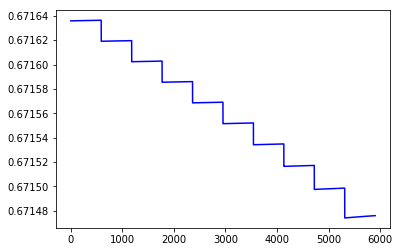

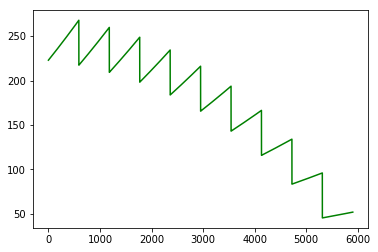

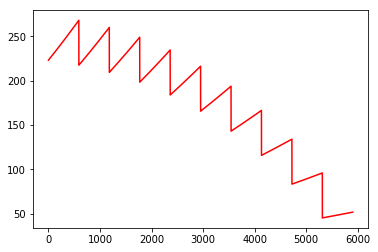

In [76]:
x = [val[0] for val in inertial_matrix_eigenvalues]
y = [val[1] for val in inertial_matrix_eigenvalues]
z = [val[2] for val in inertial_matrix_eigenvalues]

# magnitudes
#mag_x = np.sqrt(sum([val[0]**2 for val in I]))
#mag_x = np.sqrt(sum([val[0]**2 for val in inertial_matrix_eigenvalues]))
#mag_x = np.sqrt(sum([val[0]**2 for val in inertial_matrix_eigenvalues]))


plt.plot(np.arange(start, len(x), dt), x,'b')
plt.figure()
#plt.xlim(0, 500)
plt.plot(np.arange(start, len(y), dt), y,'g')
plt.figure()
plt.plot(np.arange(start, len(z), dt), z,'r')

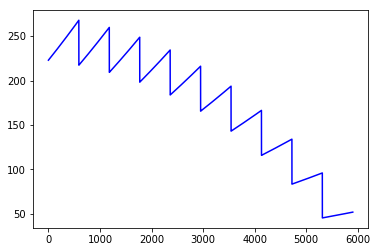

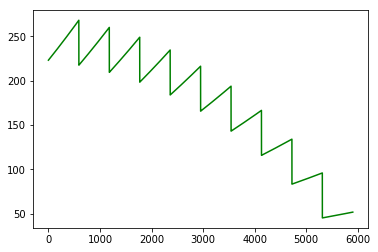

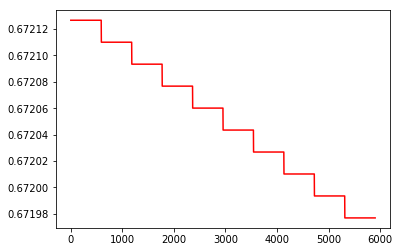

In [75]:
times = np.arange(start, len(mag_x), dt)

mag_x = []
mag_y = []
mag_z = []

for mat in I:
    x_sq_sum = 0
    y_sq_sum = 0
    z_sq_sum = 0
    
    for row in mat:
        x_sq_sum += row[0]**2
        y_sq_sum += row[1]**2
        z_sq_sum += row[2]**2
    
    mag_x.append(x_sq_sum ** 0.5)
    mag_y.append(y_sq_sum ** 0.5)
    mag_z.append(z_sq_sum ** 0.5)

plt.plot(times, mag_x,'b')
plt.figure()
#plt.xlim(0, 500)
plt.plot(times, mag_y,'g')
plt.figure()
plt.plot(times, mag_z,'r')